In [1]:
from agents import DPM_Agent, agent_loss
from trading_env.environment import TradingEnv

In [2]:
import dill
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
yf_file = "./data/archive_data/yf_data.dill"
with open(yf_file,'rb') as dill_file:
    yf_df = dill.load(dill_file)
    

In [4]:
print('Head of data set:')
yf_df.head()

Head of data set:


,Date,Symbol,high,low,open,close,volume,adjclose
0,2000-01-03,AAPL,1.004464,0.907924,0.936384,0.999442,535796800,0.859423
1,2000-01-04,AAPL,0.987723,0.903460,0.966518,0.915179,512377600,0.786965
2,2000-01-05,AAPL,0.987165,0.919643,0.926339,0.928571,778321600,0.798481
3,2000-01-06,AAPL,0.955357,0.848214,0.947545,0.848214,767972800,0.729382
4,2000-01-07,AAPL,0.901786,0.852679,0.861607,0.888393,460734400,0.763932


In [5]:
print('Tail of data set:')
yf_df.tail()

Tail of data set:


,Date,Symbol,high,low,open,close,volume,adjclose
110959,2020-12-24,WMT,144.389999,143.179993,143.539993,143.500000,3018200,142.344345
110960,2020-12-28,WMT,145.300003,143.330002,144.039993,145.220001,6448300,144.050491
110961,2020-12-29,WMT,145.850006,143.589996,145.639999,144.300003,5979400,143.137909
110962,2020-12-30,WMT,145.149994,143.940002,144.880005,144.179993,6250400,143.018860
110963,2020-12-31,WMT,144.270004,142.850006,144.199997,144.149994,5938000,142.989090


In [6]:
# Generate array of symbols in the yf dataframe
symbols = yf_df['Symbol'].unique()

# Create date masks to partition data 
training_start = '2000-1-1'
training_end = '2016-12-31'
training_mask = (yf_df['Date'] >= training_start) & (yf_df['Date'] <= training_end) 
validation_start = '2017-1-1'
validation_end = '2018-12-31'
validation_mask = (yf_df['Date'] >= validation_start) & (yf_df['Date'] <= validation_end) 
test_start = '2019-1-1'
test_end = '2020-12-31'
test_mask = (yf_df['Date'] >= test_start) & (yf_df['Date'] <= test_end)

# Select stock data for each symbol,
# partition into training, validation, or test set
training_data = [yf_df[(yf_df['Symbol'] == symbol) & training_mask] for symbol in symbols]
validation_data = [yf_df[(yf_df['Symbol'] == symbol) & validation_mask] for symbol in symbols]
test_data = [yf_df[(yf_df['Symbol'] == symbol) & test_mask] for symbol in symbols]
  
validation_dates = validation_data[0]['Date']
test_dates = test_data[0]['Date']

# Select only high, low, open, and close prices for each stock
training_data = np.array([df.iloc[:,2:6].to_numpy() for df in training_data])
validation_data = np.array([df.iloc[:,2:6].to_numpy() for df in validation_data])
test_data = np.array([df.iloc[:,2:6].to_numpy() for df in test_data])

# Save the test data for post traning
with open('test_data.dill','wb') as dill_file:
    dill.dump({'dates':test_dates,'data':test_data},dill_file)

In [7]:
# Batch the data
data_len = training_data.shape[1]
div = list(map(int,np.linspace(0,data_len,41)))
batched_training_data = np.split(training_data,div[1:-1],axis=1)


In [8]:
# Create environment
validation_env = TradingEnv(validation_data)
# get dimensions of data
n_stocks = validation_env.n_stocks
n_stock_feats = validation_env.n_stock_feats
start_idx = validation_env._start_tick
# Create DPM agent
agent = DPM_Agent(n_stocks,n_stock_feats)

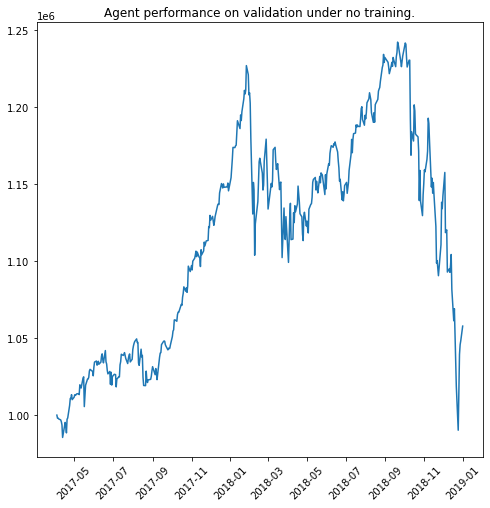

Initial value of portfolio:  1000000.0
Final value of portfolio:  1057745.9
Maximum value of portfolio:  1241996.5
Minimum value of portfolio:  985530.4


In [9]:
# Simulate untrained agent to view baseline
loss = agent_loss(validation_env,agent,n_stocks)
plt.figure(figsize=(8,8))
plt.plot(validation_dates[start_idx:], validation_env.portfolio_value_hist)
plt.xticks(rotation=45)
plt.title('Agent performance on validation under no training.')
plt.show()
print('Initial value of portfolio: ',validation_env.portfolio_value_hist[0].numpy())
print('Final value of portfolio: ',validation_env.portfolio_value_hist[-1].numpy())
print('Maximum value of portfolio: ',max(validation_env.portfolio_value_hist).numpy())
print('Minimum value of portfolio: ',min(validation_env.portfolio_value_hist).numpy())

Final portfolio value on the validation set:
After 1 training epochs:  1074243.8
After 2 training epochs:  1340754.8
After 3 training epochs:  1295649.2
After 4 training epochs:  1295971.9
After 5 training epochs:  1296283.9
After 6 training epochs:  1296597.9
After 7 training epochs:  1296904.2
After 8 training epochs:  1297212.8
After 9 training epochs:  1297522.1
After 10 training epochs:  1297817.1
After 11 training epochs:  1298105.6
After 12 training epochs:  1298386.0
After 13 training epochs:  1298650.4
After 14 training epochs:  1298919.1
After 15 training epochs:  1299172.2
After 16 training epochs:  1299419.1
After 17 training epochs:  1299661.8
After 18 training epochs:  1299899.0
After 19 training epochs:  1300134.8
After 20 training epochs:  1300361.9
After 21 training epochs:  1300591.6
After 22 training epochs:  1300820.8
After 23 training epochs:  1301076.2
After 24 training epochs:  1301322.2
After 25 training epochs:  1301568.4
After 26 training epochs:  1301804.5
Af

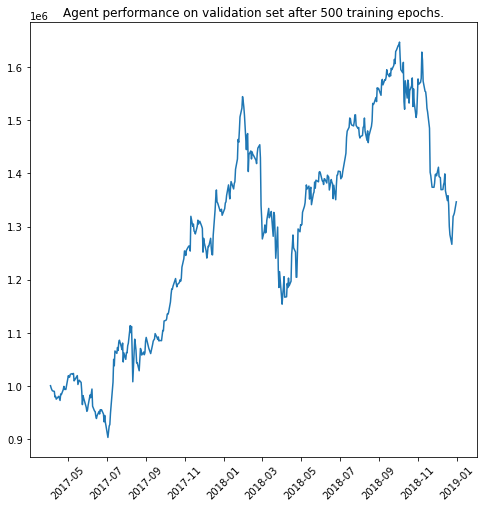

Initial value of portfolio:  1000000.0
Final value of portfolio:  1346555.4
Maximum value of portfolio:  1647646.6
Minimum value of portfolio:  902443.7


In [10]:

EPOCHS = 500
print('Final portfolio value on the validation set:')
for epoch in range(EPOCHS):

    for batch in batched_training_data:
        # Create new environment for current batch
        env = TradingEnv(batch)

        # Train on current batch
        with tf.GradientTape() as tape:
            tape.watch(agent.model.trainable_variables)
            loss = agent_loss(env,agent,n_stocks)
        grad = tape.gradient(loss,agent.model.trainable_variables)
        grad = [g / tf.reduce_mean(tf.abs(g)) for g in grad]
        agent.opt.apply_gradients(zip(grad,agent.model.trainable_variables))

    # Evaluate performance on validation set:
    loss = agent_loss(validation_env,agent,n_stocks)
    print(f'After {epoch+1} training epochs: ',validation_env.portfolio_value_hist[-1].numpy())

    #if epoch < EPOCHS/10:
    #    for x in agent.model.trainable_variables:
    #        y = x+tf.random.normal(x.shape,stddev=1e-3)
    #        x.assign(y)

plt.figure(figsize=(8,8))
plt.plot(validation_dates[start_idx:], validation_env.portfolio_value_hist)
plt.xticks(rotation=45)
plt.title(f'Agent performance on validation set after {EPOCHS} training epochs.')
plt.show()
print('Initial value of portfolio: ',validation_env.portfolio_value_hist[0].numpy())
print('Final value of portfolio: ',validation_env.portfolio_value_hist[-1].numpy())
print('Maximum value of portfolio: ',max(validation_env.portfolio_value_hist).numpy())
print('Minimum value of portfolio: ',min(validation_env.portfolio_value_hist).numpy())

In [11]:
with open('dpm_agent.dill','wb') as dill_file:
    dill.dump(agent, dill_file)